## 

In [1]:
"""
Created on Wed Jul  7 17:46:12 2021

@author: Schroeder
"""

from turtle import color
import matplotlib
from matplotlib import colors

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from pathlib import Path
import csv

from datetime import datetime
from datetime import date
import calendar

import os
from os import listdir
from os.path import isfile, join

import sys, getopt

# Imports
#from pandas_datareader import data as pdr
#from yahoo_fin import stock_info as si

import numpy as np
import numpy as np
from sklearn import linear_model
import scipy.stats


import numpy as np
from sklearn import linear_model

import pandas as pd

import plotly.io as pio
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot

from pandas import ExcelWriter



#from sympy import maximum

import RSI_strat_SETUP




#init_notebook_mode()

from lib import Indikatoren

#pio.renderers.default = "vscode"
#pio.renderers.default = "browser"


def figupdate_nonHist(figure,xtit="",ytit=""):
    figure.update_layout(
        height=500,
        xaxis_title=xtit,
        yaxis_title=ytit,
        font=dict(
                family="Arial",
                size=8,
                color='#000000'
            ),
        )
    figure.show()

def figupdate(figure):
    figure.update_layout(
        height=500,
        font=dict(
                family="Arial",
                size=8,
                color='#000000'
            ),
        )
    figure.show()




#Relative Strength Index
def RSI(df, n):
    #df["EMA200"]=df["Factor"].ewm(span=200,adjust=False).mean()
    close = df["Close"]
    delta = close.diff()
# Get rid of the first row, which is NaN since it did not have a previous
# row to calculate the differences
    delta = delta[1:]

# Make the positive gains (up) and negative gains (down) Series
    up, down = delta.clip(lower=0), delta.clip(upper=0).abs()

# Calculate the RSI based on EWMA
# Reminder: Try to provide at least `window_length * 4` data points!
    roll_up = up.rolling(n).mean()
    roll_down = down.rolling(n).mean()
    rs = roll_up / roll_down
    rsi_ema = 100.0 - (100.0 / (1.0 + rs))

# Calculate the RSI based on SMA
    roll_up = up.rolling(n).mean()
    roll_down = down.rolling(n).mean()
    rs = roll_up / roll_down
    rsi_sma = 100.0 - (100.0 / (1.0 + rs))



    df["rsi_ewma"]=rsi_ema
    df["rsi_sma"]=rsi_sma
    return df

hier:  C:\Temp\Trading\ETFS\Analyse_data


In [2]:
def main(stock,t_bwd,t_fwd,r_bwd, roll_window, condi):


    mypath = RSI_strat_SETUP.mypath

    #onlyfiles = [f for f in listdir(mypath) if (isfile(join(mypath, f)) and not f.startswith("_")) ]

    b=[]
    c=[]
    figs=[]
    counter  = 0

    ###########################
    ##########################
    time_gap_fwd = t_fwd
    time_gap_back = t_bwd
    rsi_threshold =75
    return_threshold = r_bwd
    my_bins = 50
    ########################
    ########################


    for ticker in [stock,]:
   
            df = pd.read_csv(mypath + "//"+ticker,sep=";",decimal=',',
                            parse_dates=True,
                            index_col=0)

            df=df.sort_index()
           
            
            df=df.truncate(before=startdatum)
            df=df.truncate(after=enddatum)

            fig_close = px.line(df, x=df.index, y="Close")
            
            
            
            fig = px.line(df, x=df.index, y=[df['MACD_day'], df['MACDsign_day'], df['MACDdif_day']])
            fig.show()
           
            fig = px.line(df, x=df.index, y=[df['MACD_week'], df['MACDsign_week'], df['MACDdif_week']])
            fig.show()
  
        

            df = RSI(df, 21)
            
            df["EMA50_dist"] = df["Factor"]-df["EMA50"]
            # Some statistics:  pecentile:
            #df.rolling(window=3, center=False).apply(lambda x: pd.Series(x).quantile(0.75))
            
            #z-Score
            ############################
            Indikatoren.Zscore_rolling(df, 'EMA50_dist',roll_window)
            
            #target_column = 'EMA50_dist'
            #roll = df[target_column].rolling(window)
            #df['z-score'] = (df[target_column] - roll.mean()) / roll.std()
            
            
            fig_zscore = px.line(df, x=df.index, y="z-score",title="z-score of Deviation of EMA_50")

            fig_zscore_close = make_subplots(rows=2,cols=1,shared_xaxes=True,subplot_titles=("Close","zscore"))
            fig_zscore_close.add_trace(fig_zscore["data"][0],row=2,col=1)
            fig_zscore_close.add_trace(fig_close["data"][0],row=1,col=1)

            fig_zscore_close.update_layout(height=600, width=1000,title_text="zscore vs. price")
            fig_zscore_close.show()
            
            #Schreibe raus den z-score
            ############################
            df["z-score"].to_csv(mypath + "fft_"+ticker,sep=";",decimal=',', float_format='%.5f',) 
            
            
            ### Formeln geprueft und korrekt:
            # ############################################################################## 
            # mit positivem time_gap in .diff(time_gap):  df[t]= (f(t)-f(t-time_gap))/f(t)
            # also Veränderung ggü. f(t)
            ### Also backward looking return !
            df["back_"+str(t_bwd)]= 100*(df["Close"].diff(t_bwd)/df["Close"])
            
            # mit negativem time_gap in .diff(time_gap):  df[t]= (f(t+time_gap)-f(t))/f(t)
            # also Veränderung ggü. f(t). Der klassische Differenzenequotient also !!!!
            ### Also forckward looking return      
            df["fwd_"+str(t_fwd)]= 100*(-df["Close"].diff(-t_fwd)/df["Close"])
            #################################################################################
           
        
        
            #### RSi Test
            #rsi_given  = df["RSI_"][df["rsi_sma"] > rsi_threshold]


            #### Percent Test #####################################################################
            #####    Wenn in time_gap_back Tagen merh als "return_threshold" rendite, dann schreibe
            ####  die  darauf folgende time_gap_fwd rendite nach "a"

            ####   select where backward threshold has been passed
            a = df["fwd_"+str(t_fwd)][df["back_"+str(t_bwd)] > r_bwd]

            a_with_threshold_backward = a.dropna()
            
            ####   select where forward threshold has been passed AS WELL :
            #a_with_threshold_backward_forward =a_with_threshold_backward[a_with_threshold_backward>=r_fwd]
            
            a_with_threshold_backward

            #################################################################################################
            
            #a_with_threshold_backward_forward.plot(kind="bar",title="P(fwd_thres AND bwd_thresH): N_bwd_&_fwd="+str(len(a_with_threshold_backward_forward))+" N_bwd:"+str(len(a)))
            
            fig00 = px.bar(a_with_threshold_backward, title = "---> Bedingung an r_bwd  erfuellt !")

            fig_true_close = make_subplots(rows=2,cols=1,shared_xaxes=True,subplot_titles=("Close","Dates when true"))
            fig_true_close.add_trace(fig00["data"][0],row=1,col=1)
            fig_true_close.add_trace(fig_close["data"][0],row=2,col=1)

            fig_true_close.update_layout(height=600, width=1000,title_text="true vs. price")
            fig_true_close.show()




            
            #figupdate_nonHist(fig00,"Datum","---> Rendite nach "+ str(t_fwd)+ " Bars" + " ab r>" + str(r_fwd))

            #a_with_threshold_backward_forward_list= a_with_threshold_backward.tolist()
            a_with_threshold_backward_list= a_with_threshold_backward.tolist()

            figs.append(px.line(df["rsi_sma"],title= "figs: 1. fig show: " + ticker))
            counter+=1


    for i in range(counter):
        figupdate(figs[i])
        


    ##### rsi Statistik:
    rsi = df["rsi_sma"].dropna()
    rsi_sma=rsi.to_list()
    rsi_sma_hist = np.histogram(rsi_sma, bins=my_bins)
    rsi_sma_hist_dist = scipy.stats.rv_histogram(rsi_sma_hist)

    ### 1. Histogramm
    rsi_sma_df = pd.DataFrame(rsi_sma)
    #rsi_sma_df.plot.hist(bins=my_bins,title="RSI Histogramm")
    tit = "RSI Historgram"
    figRSIHist = px.histogram(rsi_sma_df, nbins=my_bins, title=tit)
    figupdate(figRSIHist)
    
    rsi_von = int(min(rsi_sma)-1.0)
    rsi_bis = int(max(rsi_sma)+1.0)

    X = np.linspace(rsi_von, rsi_bis,my_bins)
 
    cu = pd.DataFrame(data=X)
    cu["rsi"]= [rsi_sma_hist_dist.cdf(X)[i] for i in range(my_bins)]
    cu = cu.set_index(0)
    cu.index.name = "RSI"
    fig1 = px.line(cu,title= "Cum. Distr. RSI: " + ticker)
    figupdate(fig1)


    ##### renditen nach time_gap_back Zeitschrittten Statistik:
    backward = df["back_"+str(t_bwd)].dropna()
    backward_list=backward.to_list()
    backward_df = pd.DataFrame(backward_list)

    ### plotte das HIstogramm der backward auf zwei arten
    #backward_df.plot.hist(bins=my_bins,title="a) back_"+str(bwd_gap)+" backward")
    fig0=px.histogram(backward_df, nbins=my_bins, title="Histogramm der Renditen r_dt mit dt ="+str(t_bwd)+"  bars.")
    figupdate(fig0)


    #### bilde das Histogrammobjekt, um die Cummulierten Wahrscienlichkeiten zu berechen
    backward_hist = np.histogram(backward, bins=my_bins)
    backward_hist_dist = scipy.stats.rv_histogram(backward_hist)

    ### 3. Histogramm der Renditen nach "time_gap_back" Tagen





    #### renditen Statistik bei gegebenen rsi  thresholds bzw. renditen absolut  !
    a_with_threshold_backward_hist = np.histogram(a_with_threshold_backward_list, bins=my_bins)
    a_with_threshold_backward_hist_dist = scipy.stats.rv_histogram(a_with_threshold_backward_hist)

    


    ### 2. Histogramm
    b_df = pd.DataFrame(a_with_threshold_backward_list)
    positiv = len(b_df[b_df[0]>0])
    negativ = len(b_df[b_df[0]<0])
    tite =  " t_bwd= -"+ str(t_bwd)+" bars,  t_fwd = "+ str(t_fwd)+ " bars "
    tite = tite +"<br>" + "Anzahl fwd Intervalle mit r(t_fwd)>0 : "+str(positiv) + "<br>" +  "Anzahl fwd Intervalle mit r(t_fwd) < 0 : "  + str(negativ) + "<br>"+ "p(r<0): " + str(round(a_with_threshold_backward_hist_dist.cdf(0),3)) + "<br>" + "p(r>0): " 
    tite = tite+ " "+str(round(1-a_with_threshold_backward_hist_dist.cdf(0),3)) + " <r>0>: " +  str(round(a_with_threshold_backward_hist_dist.mean(),2)) + "<br>" + condi
    #ax = b_df.plot.hist(bins=my_bins,title="a)"+tit)
    fig2 = px.histogram(b_df, nbins=my_bins, title=tite)
    figupdate(fig2)


    ###############################################################
    ## cummulative wahrschienlichkeiten anzeigen

    c_von = int(min( a_with_threshold_backward_list)-1.0)
    c_bis = int(max( a_with_threshold_backward_list)+1.0)

    X = np.linspace(c_von, c_bis,my_bins)

    cu = pd.DataFrame(data=X)
    cu["p"]= [a_with_threshold_backward_hist_dist.cdf(X)[i] for i in range(my_bins)]
    cu = cu.set_index(0)
    cu.index.name = "return[%]"
    tite = "Wahrscheinlkeiten: Given t_bwd= -"+ str(t_bwd)+" bars and r_bwd >" + str(r_bwd) 
    tite = tite + ": How is distr. of rendite after " + str(t_fwd)+ "more bars ?" 
    fig3 = px.line(cu, title=tite)
    figupdate(fig3)

    

    a_von = int(min( backward_list)-1.0)
    a_bis = int(max( backward_list)+1.0)

    Y = np.linspace(a_von, a_bis,my_bins)
    
    cu = pd.DataFrame(data=Y)
    cu["p"]= [backward_hist_dist.cdf(Y)[i] for i in range(my_bins)]
    cu = cu.set_index(0)
    cu.index.name = "return[%]"
    fig4 = px.line(cu, title="Cum.Prob. der Renditen, mit dt= -"+ str(t_bwd)+" bars" + "<br>" +" ohne Bedingung an Renditen")
    figupdate_nonHist(fig4)
    #fig4.write_html(RSI_strat_SETUP.output_path + "Cu.Prob.OHNE Incident.hml")
    
    ### 
    sns.set(style = "darkgrid")
    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')

    x = df['z-score']
    y = df['Percent Change']
    z = df['ATR20']
    ####   ass
    ax.set_xlabel("z")
    ax.set_ylabel("%")
    ax.set_zlabel("ATR20")

    ax.scatter(x, y, z)


    plt.show()

    df["time"]= df.reset_index().index
    sns.scatterplot(data=df,x="z-score",y="Percent Change",hue="ATR20",size="time")




    ##RSI_strat_SETUP.figures_to_html([fig, figs[0],figRSIHist,fig0,fig1,fig2,fig3,fig4],RSI_strat_SETUP.output_path + "dashboard.html")




    """ fig2 = px.histogram(df["d_"+"int_val"+"d"], histnorm='probability density', nbins=bin_val)

    st.plotly_chart(fig2) """

# Bei Conditional Probs:  $\Phi(r,\Delta t_{fwd})\|_{r(-\Delta t_{bwd})= r_{bwd}}$
Gegeben Zeitpunkte, in denen innerhalb der letzten  $t_{bwd}$ "Balken" eine Rendite von (groesser, kleiner) als  $r_{bwd}$ erzielt wurde: Wie ist die Verteilung der Rendien nach $\Delta t = t_{fwd}$ Balken. Also bedingte Wahrschinlichkeit nach einem Ereignis $[r_{bwd},t_{bwd}]$

# 

# Set the TimeIntervall along which to analyse

In [3]:
startdatum = "2018-07-01"
enddatum = "2022-10-04"
roll_window = 200

# Backward: Suche Zeitpunkte,  vor welchen innerhalb bwd Zeitschritte vorher soll midestens  $r_{bwd}$ erzielt wurde 

In [4]:
t_bwd = 37
r_bwd = 28

In [5]:
t_bwd = 10
r_bwd = -100
t_fwd=  10


# Erklaerender Satz:

In [6]:
rational  = "Nach " + str(t_bwd) + " Balken und r > " + str(r_bwd)
rational = rational + "% Rendite"+": Wie sieht die Verteilung der Renditen nach weiteren "+str(t_fwd) + " Balken aus."
rational

'Nach 10 Balken und r > -100% Rendite: Wie sieht die Verteilung der Renditen nach weiteren 10 Balken aus.'

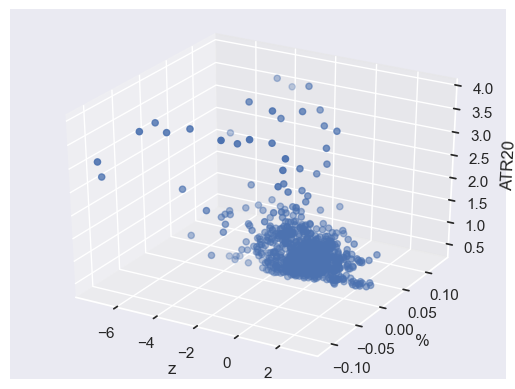

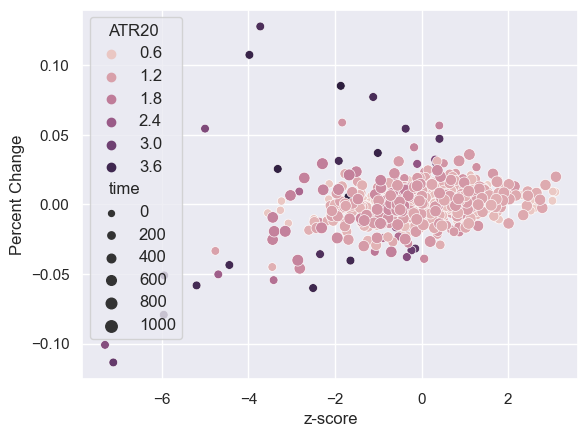

In [7]:
#main(stock,          back_gap, fwd_gap, threshold rendite backward, threshold renidte forward,comment )

main("holc_data.csv",  t_bwd   ,  t_fwd       , r_bwd , roll_window, rational)

